## Marketing Mix Modeling
#### By Kevin Eddy
For this project I'm using the dataset found in the following link: https://www.kaggle.com/datasets/orosas/marketing-mix-dataset

Given the proliferation of marketing channels, it is increasingly important for marketing teams to understand the impact of different types of advertising on sales. This project uses data from Facebook, TikTok, and AdWords to help the marketing team to:

 - Identify the most effective marketing activities for driving sales.
 - Optimize their marketing budgets by allocating more money to the most effective activities.
 - Measure the impact of marketing campaigns on sales.
 - Forecast future sales.
 
### The Goal
In the end, we want to be able to answer questions such as:

    How much of the $15,904.11 sales in the week ending on 2021–10–10 was generated by Meta advertising? And how much by TikTok and AdWords? And what is the baseline, i.e. the number of sales we would have had without any advertising?

If our model can accurately predict sales, we can use it to calculate return on investment (ROI) and optimize spending, which are the ultimate goals of most companies. 

Additive models are best suited for MMM because they allow us to easily decompose sales. This means that we can identify the specific impact of each marketing activity on sales. Other models, such as random forests, gradient boosting, and neural networks, do not allow for this decomposition.


For the first half of this analysis we will use a linear regression model because it is the simplest representative of additive models.

In the second half we will improve our model to include advertising adstock which will allow us to imcorporate the effect of diminishing returns.

In [1]:
# Import Libraries 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd

In [2]:
df = pd.read_csv('/Users/kevineddy/Desktop/Data Projects/Marketing Mix Modeling/marketing_mix.csv',
    parse_dates=['Date'],
    index_col='Date'
)

In [3]:
df.sample(10)

,TikTok,Facebook,Google Ads,Sales
Date,,,,
2019-02-10,0.00,0.00,1686.60,7854.78
2020-08-09,11352.87,4575.68,1934.87,14452.13
2018-06-17,8515.67,4006.88,0.00,11093.55
2018-08-26,0.00,5387.28,0.00,7399.92
2020-03-29,0.00,4497.18,1829.48,12297.33
2020-04-19,11844.41,0.00,2002.30,14199.63
2021-05-30,0.00,0.00,1641.15,7715.63
2021-04-04,0.00,6047.97,1873.72,13543.21
2018-11-11,0.00,0.00,0.00,10047.41


In [4]:
df.describe()

,TikTok,Facebook,Google Ads,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,2946.207650,2213.585050,1520.722550,10668.141500
std,4749.646908,2505.967886,870.764354,2700.706683
min,0.000000,0.000000,0.000000,4532.330000
25%,0.000000,0.000000,1657.195000,8396.942500
50%,0.000000,0.000000,1918.990000,10853.105000
75%,7938.527500,4624.027500,2069.767500,12566.995000
max,13901.550000,7696.220000,2518.880000,17668.340000


In [5]:
# Building our linear regression model
X = df.drop(columns=['Sales'])
y = df['Sales']

lr = LinearRegression()

print(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))

[0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]


In [6]:
lr.fit(X, y) # refit the model with the complete dataset

print('Coefficients:', lr.coef_)
print('Intercept:', lr.intercept_)

Coefficients: [0.35968382 0.48833246 1.2159193 ]
Intercept: 6678.39693360616


We can now plug in what we found to answer our question *How much of the 15,904.11 sales in the week ending on 2021–10–10 was generated by Meta advertising? And how much by TikTok and AdWords?*


Sales = f(TikTok) + g(Facebook) + h(AdWords) + Base

Sales = 0.36(TikTok) + 0.49(Facebook) + 1.22 + 6679.40

In [7]:
print(lr.predict(([[11543.58, 4615.35, 2518.88]])))

[16147.01594158]


/Users/kevineddy/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


We can see that the prediction is a little off from the expected $15,904.11. To fix this we can multiply contributions and baseline by a correction factor of correction_factor = 15904.11 / 16147.0159 ≈ 0.985

In [8]:
correction_factor = 15904.11/16147.0159
print(correction_factor)

0.9849566073691672


In [9]:
contribution_tiktok = correction_factor * (0.36 * 11543.58)
contribution_facebook = correction_factor * (0.49 * 4615.35)
contribution_adwords = correction_factor * (1.22 * 2518.88 )
contribution_base = correction_factor * (6678.40)

print('Contribution of TikTok: ', + contribution_tiktok)
print('Contribution of Facebook: ', + contribution_facebook)
print('Contribution of AdWords: ', + contribution_adwords)
print('Contribution of Base: ', + contribution_base)
print('Everything Added Up:', + 4089.57 + 2219.93 + 3016.68 + 6577.93)

Contribution of TikTok:  4093.1731417300457
Contribution of Facebook:  2227.5005441324306
Contribution of AdWords:  3026.804748987459
Contribution of Base:  6577.934206654246
Everything Added Up: 15904.11


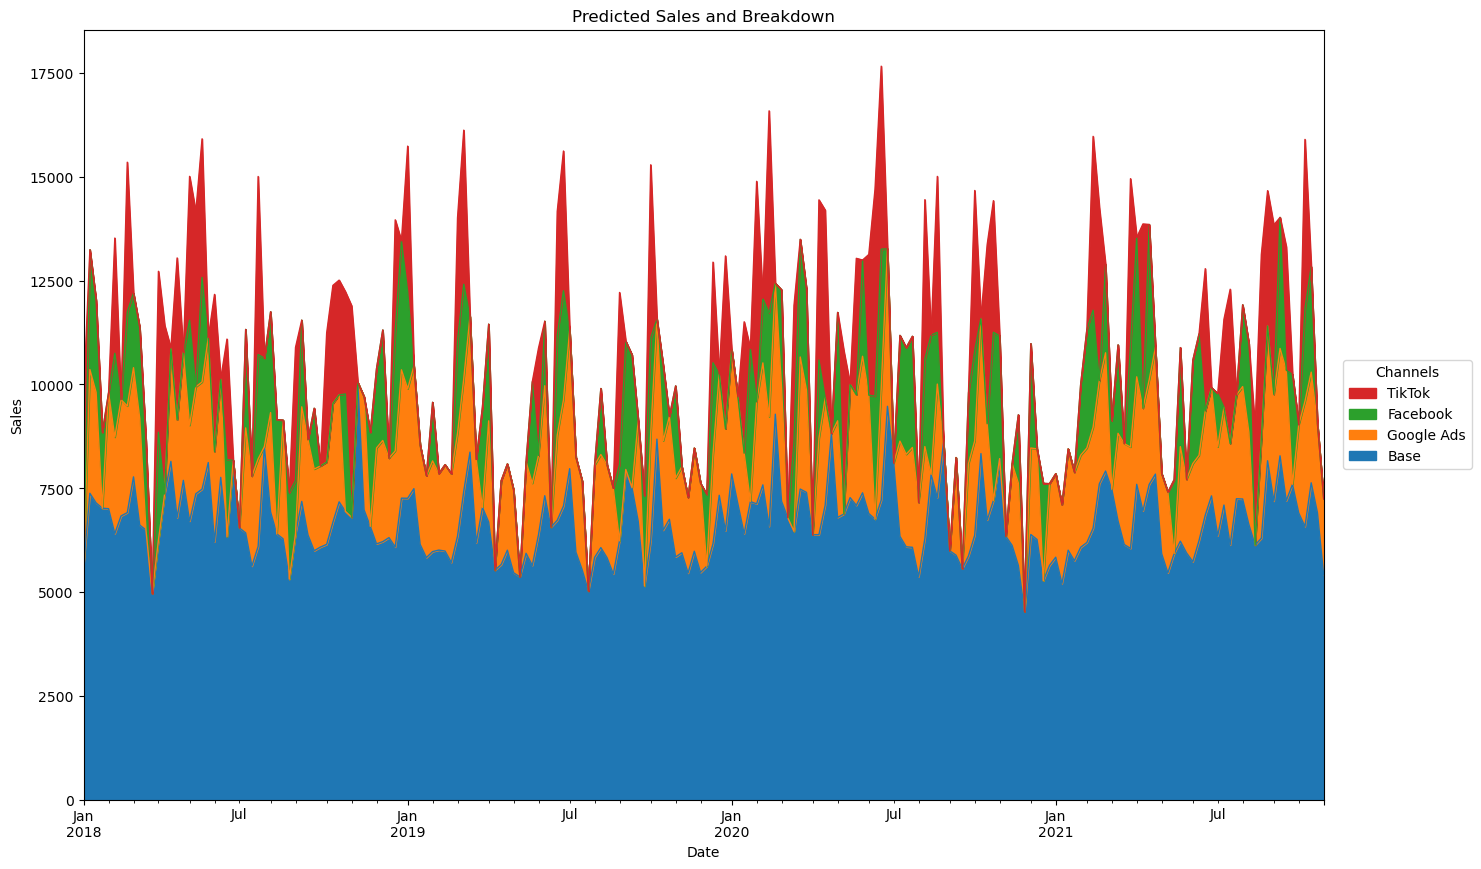

In [10]:
# Create a contribution plot 
weights = pd.Series(
    lr.coef_,
    index=X.columns
)

base = lr.intercept_

unadj_contributions = X.mul(weights).assign(Base=base)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    ) # contains all contributions for each day

ax = (adj_contributions[['Base', 'Google Ads', 'Facebook', 'TikTok']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

### Computing the Return on Investment (ROI)
We can now determine which channel was the best in terms of ROI, a number that measures the efficiency. 

The formula:

channel_ROI = Sales from the channel / channel spendings

In [11]:
#tiktok
sales_from_tiktok = adj_contributions['TikTok'].sum()
spendings_on_tiktok = df['TikTok'].sum()
tiktok_roi = sales_from_tiktok / spendings_on_tiktok

#facebook
sales_from_facebook = adj_contributions['Facebook'].sum()
spendings_on_facebook = df['Facebook'].sum()
facebook_roi = sales_from_facebook / spendings_on_facebook

#Adwords
sales_from_adwords = adj_contributions['Google Ads'].sum()
spendings_on_adwords = df['Google Ads'].sum()
adwords_roi = sales_from_adwords / spendings_on_adwords

print('TikTok ROI: ', + tiktok_roi)
print('Facebook ROI: ', + facebook_roi)
print('AdWords ROI: ', + adwords_roi)

TikTok ROI:  0.360245007135532
Facebook ROI:  0.48949589369308094
AdWords ROI:  1.214728483619404


#### Findings
Our simple marketing mix model found that AdWords was the most efficient way to generate sales, with a return on investment (ROI) of 1.21 per dollar spent on ads. TikTok and Facebook ads generated less than $1 in sales per dollar spent.

However, it is important to note that this model is too simple to rely on. The model assumes that sales will continue to grow with more ad spend. This isn't realistic and there will be a point at which additional ad spend starts to generate diminishing returns.

Overall, the model provides some useful insights, but there are more sophisticated models that take into account additional factors to provide more accurate predictions of sales and ROI.

### Improving the Model
Let's improve our model to include advertising adstock which will allow us to imcorporate the effect of diminishing returns.

#### Saturation Effect

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted, check_array

class ExponentialSaturation(BaseEstimator, TransformerMixin):
    def __init__(self, a=1.):
        self.a = a
        
    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True) # from BaseEstimator
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False) # from BaseEstimator
        return 1 - np.exp(-self.a*X)

#### Carryover Effect
We want to partially carry over spending from week one to the following weeks in an exponential way.

In [22]:
from scipy.signal import convolve2d
import numpy as np

class ExponentialCarryover(BaseEstimator, TransformerMixin):
    def __init__(self, strength=0.5, length=1):
        self.strength = strength
        self.length = length

    def fit(self, X, y=None):
        X = check_array(X)
        self._check_n_features(X, reset=True)
        self.sliding_window_ = (
            self.strength ** np.arange(self.length + 1)
        ).reshape(-1, 1)
        return self

    def transform(self, X: np.ndarray):
        check_is_fitted(self)
        X = check_array(X)
        self._check_n_features(X, reset=False)
        convolution = convolve2d(X, self.sliding_window_)
        if self.length > 0:
            convolution = convolution[: -self.length]
        return convolution

#### Model Pipeline

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

adstock = ColumnTransformer(
    [
     #### TikTok block ####
     ('tiktok_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['TikTok']),
     ('facebook_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Facebook']),
     ('adwords_pipe', Pipeline([
                           ('carryover', ExponentialCarryover()),
                           ('saturation', ExponentialSaturation())
     ]), ['Google Ads']),
    ],
    remainder='passthrough'
)

model = Pipeline([
                  ('adstock', adstock),
                  ('regression', LinearRegression())
])

In [15]:
# Training Data
X = df.drop(columns=['Sales'])
y = df['Sales']

model.fit(X, y)

print(cross_val_score(model, X, y, cv=TimeSeriesSplit()).mean())

0.5527190073236669


Our model is not performing as well as we expected, with a cross-validated R² of 0.55. The old, simpler model had a cross-validated R² of 0.72, so there is room for improvement.

To improve the performance of our model, we will use Bayesian optimization to find the best hyperparameters for a machine learning model. Bayesian optimization is a sequential model-based optimization algorithm that learns from previous evaluations to find the next most promising hyperparameter configuration and allows for extrapolation capabilities.

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

tuned_model = RandomizedSearchCV(
    estimator=model,
    param_distributions={
        'adstock__tiktok_pipe__carryover__strength': uniform(0, 1),
        'adstock__tiktok_pipe__carryover__length': randint(0, 6),
        'adstock__facebook_pipe__saturation__a': uniform(0, 0.01),
        'adstock__facebook_pipe__carryover__strength': uniform(0, 1),
        'adstock__facebook_pipe__carryover__length': randint(0, 6),
        'adstock__facebook_pipe__saturation__a': uniform(0, 0.01),
        'adstock__adwords_pipe__carryover__strength': uniform(0, 1),
        'adstock__adwords_pipe__carryover__length': randint(0, 6),
        'adstock__adwords_pipe__saturation__a': uniform(0, 0.01),
    },
    n_iter=1000,
    cv=TimeSeriesSplit(),
    random_state=0
)

# call tuned_model
tuned_model.fit(X, y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('adstock',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('tiktok_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('saturation',
                                                                                                ExponentialSaturation())]),
                                                                               ['TikTok']),
                                                                              ('facebook_pipe',
                                                                               Pipeline(steps=[('carryover'...
                                        'adstock__facebook_pipe__saturation__a': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x179aaeb90>,
                                        'adstock__tiktok_pipe__carryover__length': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x104c95950>,
                                        'adstock__tiktok_pipe__carryover__strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x179b03b90>},
                   random_state=0)

In [39]:
print(cross_val_score(tuned_model, X, y, cv=TimeSeriesSplit()).mean())

0.7460062168822779


Our new model is performing better, with a cross-validated R² of 0.75. A sizeable increase from the original model which had a cross-validated R² of 0.55.

In [35]:
print(tuned_model.best_params_)

print('Coeficients: ', + tuned_model.best_estimator_.named_steps['regression'].coef_)
print('Intercept: ', + tuned_model.best_estimator_.named_steps['regression'].intercept_)

{'adstock__adwords_pipe__carryover__length': 0, 'adstock__adwords_pipe__carryover__strength': 0.38085334257877945, 'adstock__adwords_pipe__saturation__a': 0.005447598583067481, 'adstock__facebook_pipe__carryover__length': 5, 'adstock__facebook_pipe__carryover__strength': 0.23464118137344636, 'adstock__facebook_pipe__saturation__a': 0.00030110435941066216, 'adstock__tiktok_pipe__carryover__length': 1, 'adstock__tiktok_pipe__carryover__strength': 0.8117741001399064}
Coeficients:  [3585.74276486 3689.24978733 2407.08534006]
Intercept:  5380.275824823231


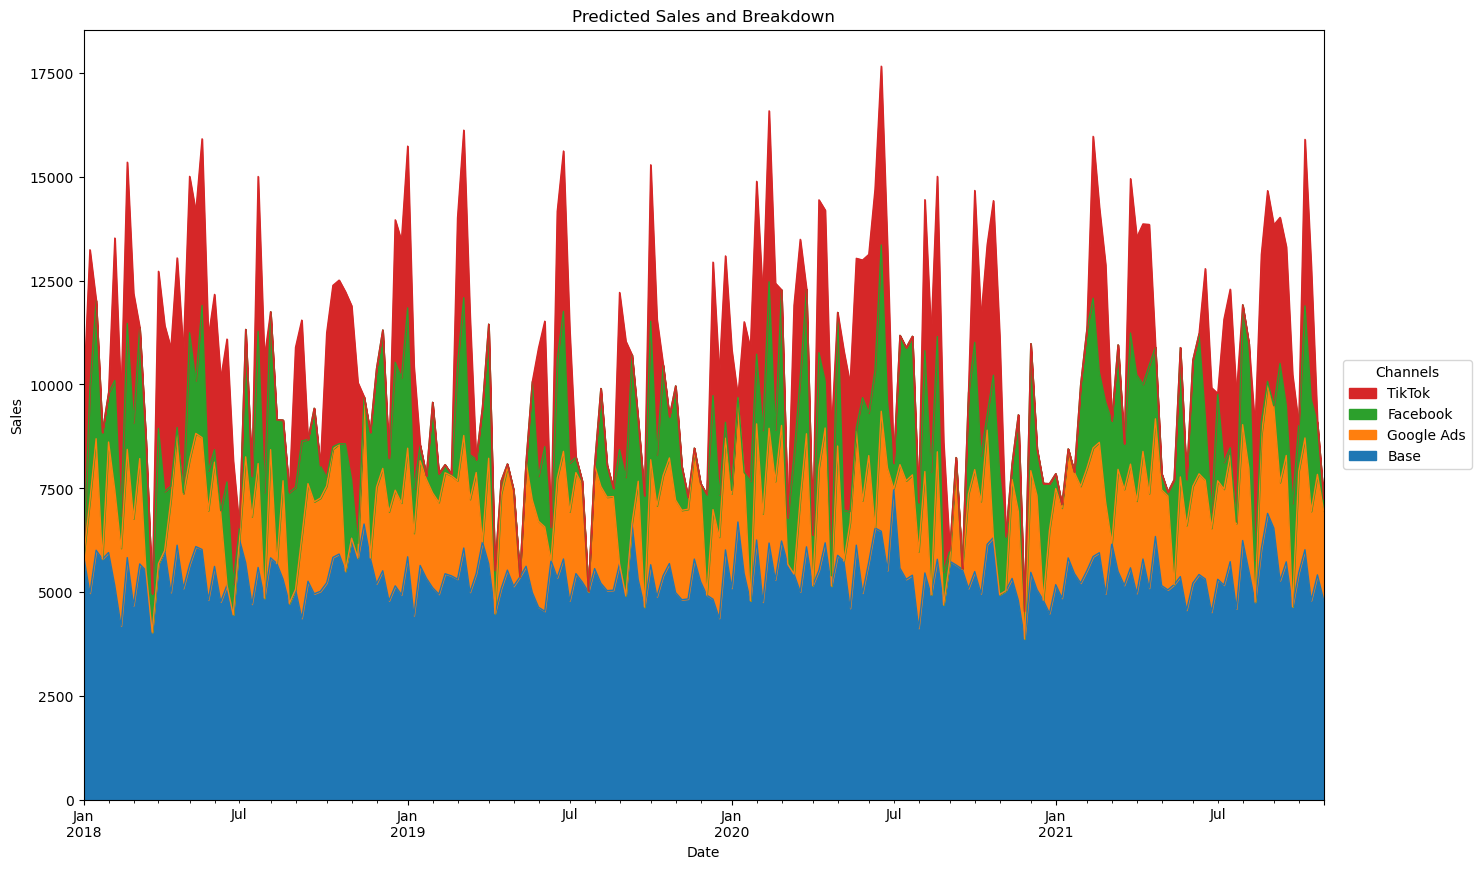

In [37]:
adstock_data = pd.DataFrame(
    tuned_model.best_estimator_.named_steps['adstock'].transform(X),
    columns=X.columns,
    index=X.index
)

weights = pd.Series(
    tuned_model.best_estimator_.named_steps['regression'].coef_,
    index=X.columns
)

base = tuned_model.best_estimator_.named_steps['regression'].intercept_

unadj_contributions = adstock_data.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions[['Base', 'Google Ads', 'Facebook', 'TikTok']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

#### Comparing Our Graphs
Now that we can compare the sales from each platform we can see that the base line is less chaotic overall. 

### Summary
Overall, this is a very simple model that only considers each profile's spending and its carryover effect (adstock). There are still some other areas of the model that we can improve to make it more predictive, such as optimizing our spending and adding non-spending data to account for other external variables that may affect each profile's performance.